## Modely na upravených datech a hledání anomálií

In [1]:
import pandas as pd
import numpy as np
import optuna
from optuna.visualization.matplotlib import plot_param_importances, plot_optimization_history
import shap
import pickle
import gower
from catboost import CatBoostClassifier, Pool

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import balanced_accuracy_score, f1_score, roc_auc_score, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from ydata_profiling import ProfileReport
from webpages.preprocessing import Preprocessor, print_metrics
np.random.seed(88)
%matplotlib inline

Načtení dat:

In [2]:
p = Preprocessor('../data_2')
dataframes = p.get_dataframes()
X_train, X_val, X_test, y_train, y_val, y_test, X_train_all, X_val_all, X_test_all = p.get_predictions_dataframe()

Profilování dat:

In [3]:
# profile = ProfileReport(X_train, title="Predictions")
# profile.to_file("Predictions_profile.html")

Základní model na upravených datech:

In [4]:
# model = CatBoostClassifier(iterations=10,
#                            depth=7,
#                            learning_rate=1,
#                            loss_function='Logloss',
#                            verbose=True,
#                            cat_features=['place_of_performance', 'public_contract_regime', 'type', 'type_of_procedure', 'distance'])
# # train the model
# model.fit(X_train, y_train)
# model.score(X_val, y_val.astype("str"))
# model.save_model("models/catboost_model_on_preprocessed_data")

Balanced accuracy: 0.7536513363164374
F1 score micro: 0.7588674876328807
F1 score macro: 0.752465061467483
RocAuc score: 0.832958581247276
Confusion matrix:


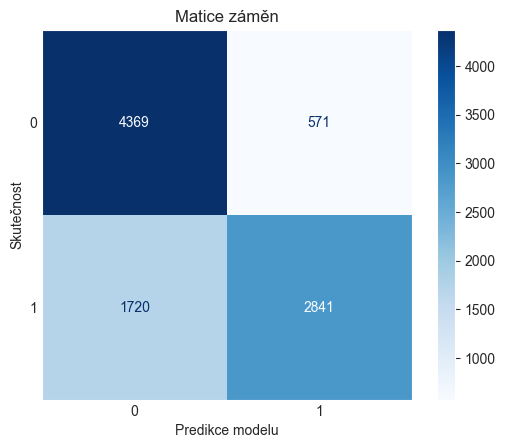

In [5]:
model = CatBoostClassifier()
model.load_model("models/catboost_model_on_preprocessed_data")
print_metrics(model, X_val, y_val)

Optimalizace hyperparametrů pomocí optuny:

In [6]:
# def objective(trial):
#     params = {
#         "iterations": trial.suggest_int("iterations", 5, 500),
#         "depth": trial.suggest_int("depth", 1, 10),
#         "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
#         "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.25, 1), # 16 parametrů - min. 4
#         "has_time": True,
#         "objective": trial.suggest_categorical("objective", ["Logloss", "MultiClass"]),
#         "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-4, 100, log=True),
#         "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]),
#     }
#     if params["bootstrap_type"] == "Bayesian":
#         params["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
#     elif params["bootstrap_type"] == "Bernoulli":
#         params["subsample"] = trial.suggest_float("subsample", 0.1, 1, log=True)
#     model = CatBoostClassifier(**params, silent=True)
#     model.fit(X_train, y_train, cat_features=['place_of_performance', 'public_contract_regime', 'type', 'type_of_procedure', 'distance'])
#     predictions = model.predict(X_val)
#     return balanced_accuracy_score(y_val.astype("str"), predictions)


In [7]:
# study = optuna.create_study(study_name="CatBoost_final_100_it", direction="maximize")
# study.optimize(objective, n_trials=100)
# with open("catboost_study_with_number_of_offers.pkl", "wb") as f:
#     pickle.dump(study, f)

Načtení studie:

In [8]:
with open("catboost_study_with_number_of_offers.pkl", "rb") as f:
    study = pickle.load(f)

Zobrazení důležitosti hyperparametrů v rámci studie:

plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.


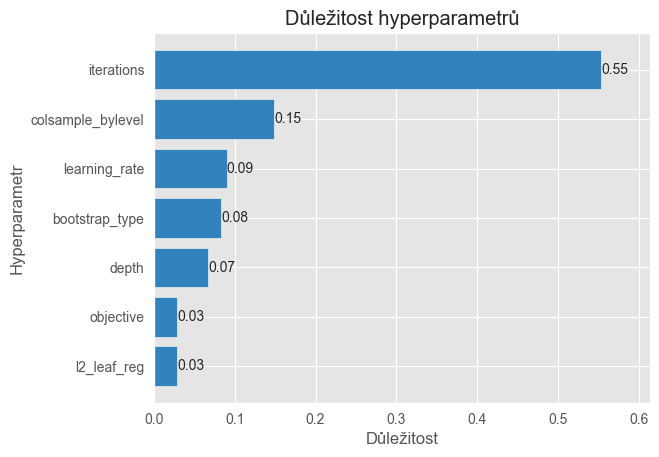

In [9]:
ax = plot_param_importances(study)
ax.set_title("", loc='left')
ax.set_title("Důležitost hyperparametrů")
ax.set_ylabel("Hyperparametr")
ax.set_xlabel("Důležitost")
ax.get_legend().remove()

In [10]:
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

  Value:  0.8073954545091415
  Params: 
    iterations: 348
    depth: 7
    learning_rate: 0.0031268540962548757
    colsample_bylevel: 0.5165553062835834
    objective: Logloss
    l2_leaf_reg: 30.523106906236013
    bootstrap_type: Bernoulli
    subsample: 0.17590954254702626


Vytvoření modelu s nejlepšími hyperparametry:

In [11]:
# model = CatBoostClassifier(**trial.params, verbose=True, cat_features=['place_of_performance', 'public_contract_regime', 'type', 'type_of_procedure', 'distance'])
# model.fit(X_train, y_train)
# 
# model.save_model("catboost_model_hyper_tuning_final")

Načtení modelu:

In [12]:
model_with_number_of_offers = CatBoostClassifier()
model_with_number_of_offers.load_model("models/catboost_model_hyper_tuning_final")

Vypočítání důležitosti příznaků z knihovny CatBoost:

In [13]:
importances = model_with_number_of_offers.get_feature_importance()
feature_importances = pd.Series(importances, index=X_val.columns).sort_values(ascending=False)

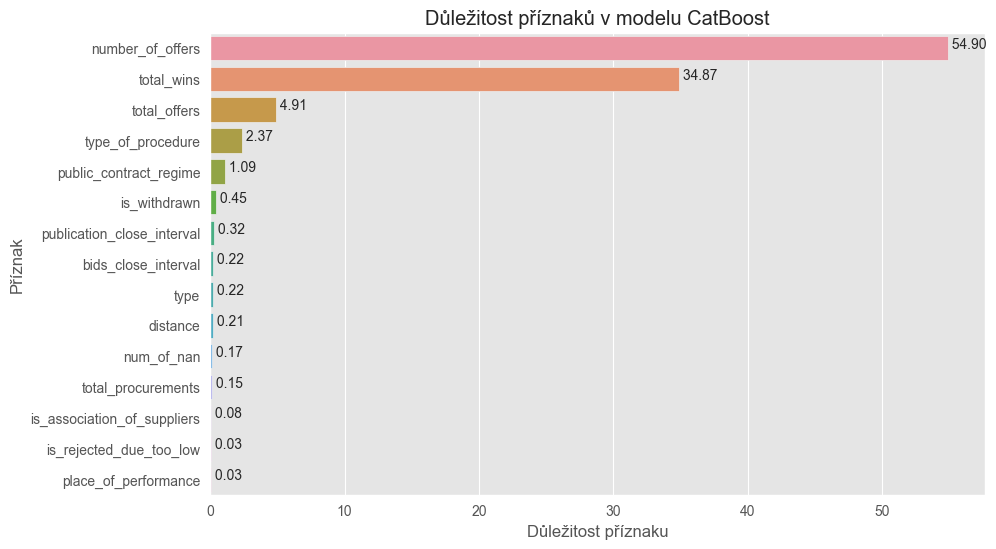

In [14]:
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances, y=feature_importances.index)
plt.xlabel('Důležitost příznaku')
plt.ylabel('Příznak')
plt.title('Důležitost příznaků v modelu CatBoost')
# add numbers for each bar
for i, v in enumerate(feature_importances):
    plt.text(v, i, ' {:1.2f}'.format(v), ha='left')

plt.show()

Text(0, 0.5, 'Příznak')

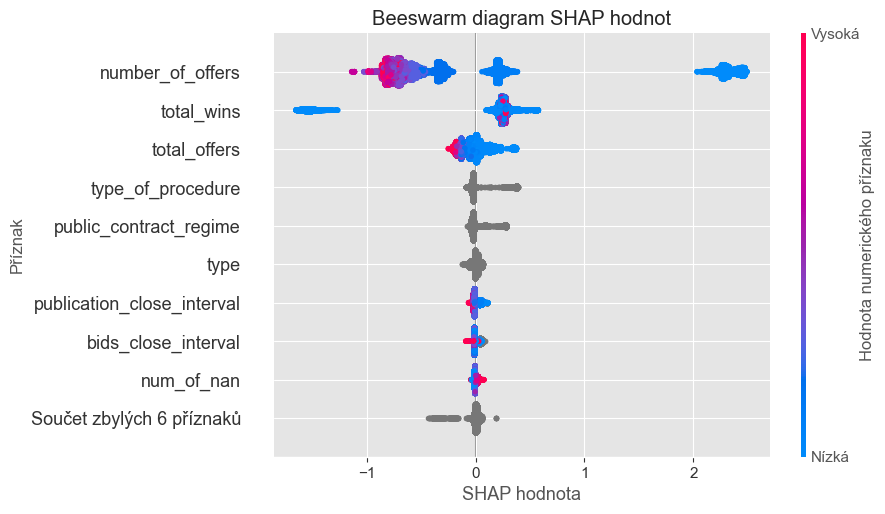

In [15]:
explainer = shap.Explainer(model_with_number_of_offers)
shap_values = explainer(X_train)
plt.close('all')
ax = shap.plots.beeswarm(shap_values, show=False, color_bar=True, color_bar_label='Hodnota numerického příznaku')
ax.set_title("Beeswarm diagram SHAP hodnot")
ax.set_xlabel("SHAP hodnota")
ax.set_ylabel("Příznak")

Text(0, 0.5, 'Příznak')

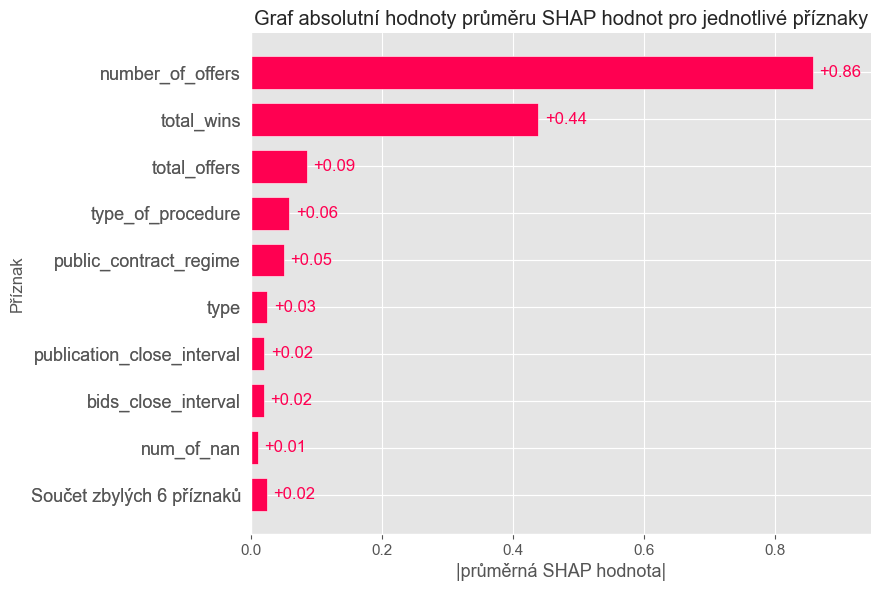

In [16]:
plt.close('all')
ax = shap.plots.bar(shap_values, show=False, max_display=10)
ax.set_title("Graf absolutní hodnoty průměru SHAP hodnot pro jednotlivé příznaky")
ax.set_xlabel("|průměrná SHAP hodnota|")
ax.set_ylabel("Příznak")


Výpočet metrik pro model s num_of_offers na validační množině:

Balanced accuracy: 0.8060126694639556
F1 score micro: 0.810125249973687
F1 score macro: 0.8065872923734849
RocAuc score: 0.8527546741560865
Confusion matrix:


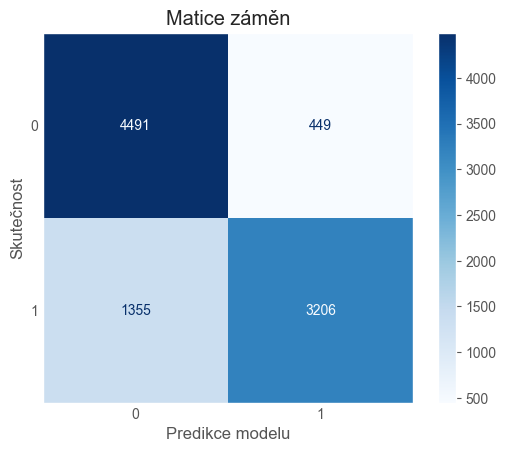

In [17]:
print_metrics(model_with_number_of_offers, X_val, y_val)

Načtení modelu bez počtu nabídek a zobrazení metrik:

In [18]:
model_without_number_of_offers = CatBoostClassifier()
model_without_number_of_offers.load_model("models/catboost_model_without_number_of_offers")

In [19]:
X_test_wo_number_of_offers = X_test.drop(columns=['number_of_offers'])
X_val_wo_number_of_offers = X_val.drop(columns=['number_of_offers'])

Balanced accuracy: 0.7221985465578169
F1 score micro: 0.7260288390695717
F1 score macro: 0.7216921711718246
RocAuc score: 0.7722571981959352
Confusion matrix:


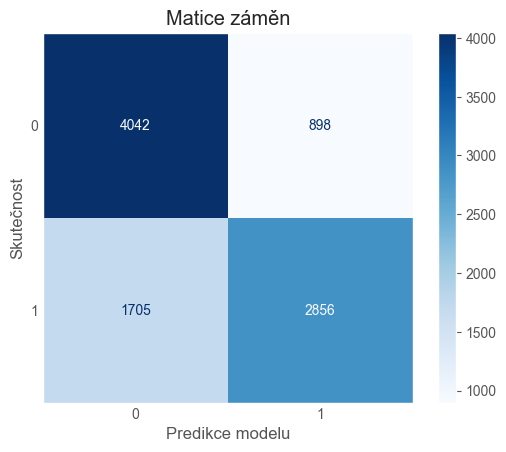

In [20]:
print_metrics(model_without_number_of_offers, X_val_wo_number_of_offers, y_val)

### Rozbor finálního modelu s vyladěnými hyperparametry na upravených datech na testovací množině:

Přesnost modelu dle místa výkonu veřejné zakázky:

In [21]:
predictions = model_with_number_of_offers.predict(X_test)
pandas_predictions = pd.DataFrame(predictions, columns=['predictions'])
data = X_test.copy()
tmp = y_test.copy()
tmp = tmp.reset_index(drop=True)
data['is_winner'] = tmp.astype("str")
data['predictions'] = pandas_predictions['predictions']
data['correct'] = data['is_winner'] == data['predictions']
data.groupby('place_of_performance')['correct'].mean().sort_values(ascending=False)

place_of_performance
BELGIQUE-BELGIË         1.000000
Hamburg                 1.000000
Bratislavský kraj       1.000000
Unknown                 0.900000
Extra-Regio             0.860000
Olomoucký kraj          0.839357
Královéhradecký kraj    0.824645
Jihomoravský kraj       0.820205
Plzeňský kraj           0.815427
Liberecký kraj          0.814103
Praha                   0.798611
Moravskoslezský kraj    0.797753
Ústecký kraj            0.797428
Pardubický kraj         0.793651
Zlínský kraj            0.792576
Karlovarský kraj        0.788820
Česká republika         0.785944
Jihočeský kraj          0.785326
Kraj Vysočina           0.780952
Středočeský kraj        0.772727
Name: correct, dtype: float64

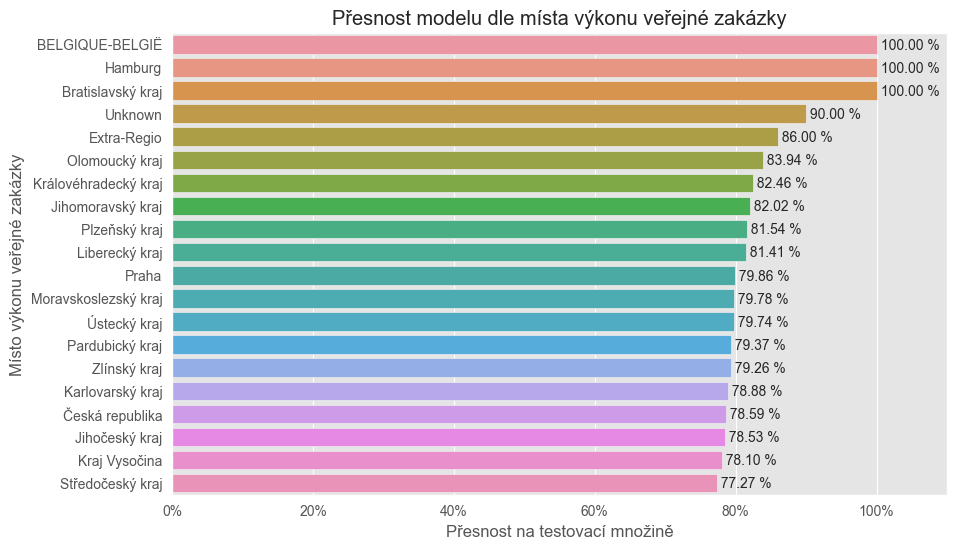

In [22]:
plt.figure(figsize=(10, 6))
barplot = sns.barplot(y='place_of_performance', x='correct', data=data, errorbar=None, order=data.groupby('place_of_performance')['correct'].mean().sort_values(ascending=False).index)

for p in barplot.patches:
        width = p.get_width()
        plt.text(width,
                 p.get_y() + p.get_height() / 2 + 0.2,
                 ' {:1.2f} %'.format(width * 100),
                 ha = 'left')

plt.xlabel('Přesnost na testovací množině')
plt.ylabel('Místo výkonu veřejné zakázky')
plt.title('Přesnost modelu dle místa výkonu veřejné zakázky')
plt.xlim(0, 1.1)
plt.xticks([0, 0.2, 0.4, 0.6, 0.8, 1], ['0%', '20%', '40%', '60%', '80%', '100%'])
plt.show()

Přesnost modelu dle NIPEZ kódu veřejné zakázky:

In [23]:
X_test_all['codes'] = (X_test_all['code_from_nipez_codelist'].str[:2]).astype("str")
X_test_all['is_winner'] = tmp.astype("str")
X_test_all['predictions'] = pandas_predictions.astype("str")

In [24]:
groups = X_test_all.groupby('codes')

In [25]:
# get accuracy for each code save them in list and sort them
codes_accuracies = {}
for name, group in groups:
    group['correct'] = group['is_winner'] == group['predictions']
    codes_accuracies[name] = group['correct'].mean()

In [26]:
codes_accuracies = dict(sorted(codes_accuracies.items(), key=lambda item: item[1], reverse=True))
codes_accuracies

{'70': 1.0,
 '76': 1.0,
 '85': 1.0,
 '75': 0.9523809523809523,
 '60': 0.9285714285714286,
 '55': 0.9130434782608695,
 '15': 0.896551724137931,
 '73': 0.8888888888888888,
 '03': 0.8846153846153846,
 'nan': 0.875,
 '90': 0.8703071672354948,
 '50': 0.868632707774799,
 '98': 0.8666666666666667,
 '80': 0.8620689655172413,
 '14': 0.8571428571428571,
 '24': 0.84375,
 '65': 0.8333333333333334,
 '72': 0.8323353293413174,
 '38': 0.8160919540229885,
 '33': 0.8149171270718232,
 '22': 0.813953488372093,
 '42': 0.8121212121212121,
 '77': 0.8109339407744874,
 '35': 0.8009259259259259,
 '30': 0.7907647907647908,
 '45': 0.7891891891891892,
 '19': 0.7857142857142857,
 '18': 0.784,
 '79': 0.7832512315270936,
 '43': 0.782608695652174,
 '92': 0.7818181818181819,
 '48': 0.7796610169491526,
 '32': 0.7791164658634538,
 '16': 0.7777777777777778,
 '34': 0.7741935483870968,
 '39': 0.771689497716895,
 '66': 0.7692307692307693,
 '31': 0.7677902621722846,
 '71': 0.7641509433962265,
 '09': 0.7597402597402597,
 '37':

In [27]:
# for each company get win ratio for is_winner and also for predictions
def get_win_ratios(data):
    win_ratio = {}
    companies_names = data["company_id"].unique()
    for name in companies_names:
        company = data[data["company_id"] == name]
        win_ratio_real = company[company["is_winner"] == "True"].shape[0] / company.shape[0]
        win_ratio_pred = company[company["predictions"] == "True"].shape[0] / company.shape[0]
        win_ratio[name] = list([win_ratio_real, win_ratio_pred, company.shape[0]])
    return win_ratio

In [28]:
def plot_win_ratio(ratio, name_of_group):
    sizes = [x[2] for x in ratio.values()]
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=[x[0] for x in ratio.values()], y=[x[1] for x in ratio.values()], size=sizes)
    #plt.text(0.5, 0.5, 'Ideální model', color='red', fontsize=12)
    plt.plot([0, 1], [0, 1], color='red', linewidth=1, alpha=0.5)
    plt.xlabel('Poměr výher reálných dat')
    plt.ylabel('Poměr výher predikcí modelu')
    plt.title(f'Poměr výher v rámci NIPEZ kódu {name_of_group}: reálná data vs predikce modelu')
    plt.show()

In [29]:
def plot_hexbin(ratio, name_of_group):
    plt.figure(figsize=(10, 6))
    hb = plt.hexbin(x=[x[0] for x in ratio.values()], y=[x[1] for x in ratio.values()], gridsize=20, cmap='Blues')
    cb = plt.colorbar(hb)
    cb.set_label('Počet nabídek od dodavatelů') # kteří mají daný poměr výher
    plt.xlabel('Poměr výher reálných dat')
    plt.ylabel('Poměr výher predikcí modelu')
    plt.title(f'Poměr výher v rámci NIPEZ kódu {name_of_group}: reálná data vs predikce modelu')
    plt.show()

In [30]:
def plot_confusion_matrix(group, name_of_group):
    confusions = confusion_matrix(group['is_winner'], group['predictions'], labels=['True', 'False'])
    ConfusionMatrixDisplay(confusions).plot(cmap='Blues')
    plt.xlabel('Predikce modelu')
    plt.ylabel('Skutečnost')
    plt.title(f'Maticová reprezentace predikcí modelu pro NIPEZ kód {name_of_group}')
    plt.tick_params(axis=u'both', which=u'both',length=0)
    plt.grid(False)
    plt.show()

In [31]:
def plot_ratios(groups, name):
    group = groups.get_group(name)
    ratio = get_win_ratios(group)
    plot_win_ratio(ratio, name_of_group=name)
    plot_hexbin(ratio, name_of_group=name)


5 nejhůře predikovatelných sektorů

In [32]:
# plot_ratios(groups, '71')
# plot_ratios(groups, '44')
# plot_ratios(groups, '64')
# plot_ratios(groups, '51')
# plot_ratios(groups, '63')

5 nejlépe predikovatelných sektorů

In [33]:
# plot_ratios(groups, '70')
# plot_ratios(groups, '76')
# plot_ratios(groups, '85')
# plot_ratios(groups, '75')
# plot_ratios(groups, '60')

In [34]:
# ratio = get_win_ratios(X_test_all)
# plot_win_ratio(ratio, name_of_group="Všechny kódy")
# plot_hexbin(ratio, name_of_group="Všechny kódy")
# plot_confusion_matrix(X_test_all, name_of_group="Všechny kódy")

Profilování správných a špatných predikcí:

In [35]:
X_test_all_correct = X_test_all[X_test_all['is_winner'] == X_test_all['predictions']].copy()
X_test_all_correct.drop(columns=['date_of_contract_close', 'date_of_publication', 'contact_person_id', 'organisation_id', 'address_id_x','code_from_nipez_codelist', 'id', 'url','address_id_y', 'bids_submission_deadline'], inplace=True)

In [36]:
type_schema = { 
               "place_of_performance": "categorical",
               "public_contract_regime": "categorical",
               "type": "categorical",
               "type_of_procedure": "categorical",
               "contracting_authority_id": "categorical",
               "company_id": "categorical",
               "contracting_authority_name": "categorical",
               "distance": "categorical",
               "codes": "categorical"}
correlations = {
            "auto": {"calculate": False},
            "pearson": {"calculate": True},
            "spearman": {"calculate": True},
            "kendall": {"calculate": True},
            "phi_k": {"calculate": True},
            "cramers": {"calculate": True}}
               

In [37]:
# report_correct = ProfileReport(X_test_all_correct, title="Correct predictions", 
#                                type_schema=type_schema, correlations=correlations, 
#                                missing_diagrams={"Heatmap": False})
# report_correct.to_file("Correct_predictions_profile.html")

In [38]:
X_test_all_wrong = X_test_all[X_test_all['is_winner'] != X_test_all['predictions']].copy()
X_test_all_wrong.drop(columns=['date_of_contract_close', 'date_of_publication', 'contact_person_id', 'organisation_id', 'address_id_x', 'id', 'url','address_id_y', 'bids_submission_deadline'], inplace=True)

In [39]:
# report_wrong = ProfileReport(X_test_all_wrong, title="Wrong predictions", 
#                              type_schema=type_schema, correlations=correlations, 
#                              missing_diagrams={"Heatmap": False})
# report_wrong.to_file("Wrong_predictions_profile.html")

In [40]:
#X_test_all['correct'] = X_test_all['is_winner'] == X_test_all['predictions']

In [41]:
correct_for_DBSCAN = X_test_all_correct.drop(columns=['is_winner', 'predictions', 'contracting_authority_name', 'contracting_authority_id', 'company_id']) 

Vytvoření grafu vývoje metrik

In [92]:
metrics_models = {
    'Logistická regrese\n(základní data)' : [0.715, 0.713, 0.782],
    'Logistická regrese\n(upravená data)' : [0.496, 0.415, 0.506],
    'CatBoost model\n(základní data)' : [0.727, 0.723, 0.794],
    'CatBoost model\n(upravená data)' : [0.754, 0.752, 0.833],
    'CatBoost model\n(bez počtu nabídek\na optimální hyperparametry)' : [0.722, 0.722, 0.772],
    'CatBoost model\n(upravená data\na optimální hyperparametry)' : [0.806, 0.807, 0.853]
}
metrics_models = pd.DataFrame(metrics_models, index=['Balanced accuracy', 'F1 score', 'AUC score'])

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


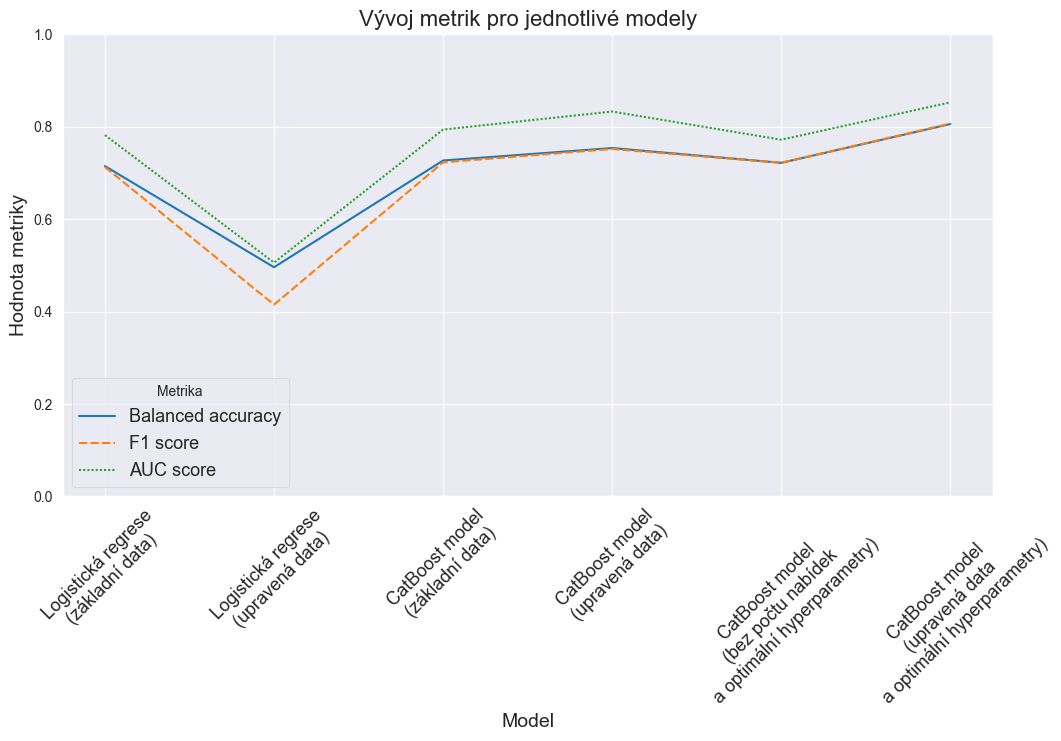

In [112]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=metrics_models.T)
plt.ylim(0,1)
plt.xlabel('Model', fontsize=14)
plt.ylabel('Hodnota metriky', fontsize=14)
plt.title('Vývoj metrik pro jednotlivé modely', fontsize=16)
plt.legend(title='Metrika', fontsize=13)
# change font size
plt.xticks(rotation=45, fontsize=13)
plt.show()

### Hledání anomálií pomocí DBSCAN:

In [42]:
from sklearn.impute import SimpleImputer

In [43]:
# get number of nan of dataframe
correct_for_DBSCAN.isna().sum()

is_association_of_suppliers              0
is_rejected_due_too_low                  0
is_withdrawn                             0
price                                 1172
price_vat                             1016
number_of_offers                         0
contract_price                           0
contract_price_vat                       0
contract_price_with_amendments           0
contract_price_with_amendments_vat       0
place_of_performance                     0
public_contract_regime                   0
type                                     0
type_of_procedure                        0
publication_close_interval               0
bids_close_interval                   2464
total_offers                             0
total_wins                               0
total_procurements                       0
distance                                 0
num_of_nan                               0
codes                                    0
dtype: int64

Vyplnění chybějících hodnot:

In [44]:
# fill nan values with median
correct_for_DBSCAN['place_of_performance'].fillna('Neuvedeno', inplace=True)
correct_for_DBSCAN['public_contract_regime'].fillna('Neuvedeno', inplace=True)
correct_for_DBSCAN['codes'].fillna(-1, inplace=True)

In [45]:
imputer = SimpleImputer(strategy='median')
correct_for_DBSCAN['price'] = imputer.fit_transform(correct_for_DBSCAN[['price']])
correct_for_DBSCAN['price_vat'] = imputer.fit_transform(correct_for_DBSCAN[['price_vat']])
correct_for_DBSCAN['bids_close_interval'] = imputer.fit_transform(correct_for_DBSCAN[['bids_close_interval']])

Napočítání Gowerovy vzdálenosti:

In [46]:
correct_for_DBSCAN.dropna(inplace=True)

In [47]:
gower_correct = gower.gower_matrix(correct_for_DBSCAN)

In [48]:
from sklearn.cluster import DBSCAN

In [49]:
from sklearn.metrics import silhouette_score
import itertools

Hledání optimálnách shluků pomocí grid search:

In [50]:
params = {
    'eps': np.arange(0.01,0.2, 0.02),
    'min_samples': np.arange(40, 70, 5)
}

def grid_search_DBSCAN(matrix, params):
    best_score = -1
    best_params = None
    for param in itertools.product(*params.values()):
        dbscan = DBSCAN(eps=param[0], min_samples=param[1], metric='precomputed')
        dbscan.fit(matrix)
        labels = dbscan.labels_
        n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
        if n_clusters_ > 1:
            score = silhouette_score(matrix, labels)
            if score > best_score:
                best_score = score
                best_params = param
    return best_params

In [51]:
# best_params = grid_search_DBSCAN(gower_correct, params)
# best_params

Shlukování pomocí DBSCAN:

In [52]:
dbscan = DBSCAN(eps=0.09, min_samples=65, metric='precomputed')
dbscan.fit(gower_correct)

DBSCAN(eps=0.09, metric='precomputed', min_samples=65)

In [53]:
labels = dbscan.labels_

In [54]:
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Počet shluků: %d" % n_clusters_)
print("Počet odlehlých pozorování: %d" % n_noise_)

Počet shluků: 4
Počet odlehlých pozorování: 2146


In [55]:
correct_for_DBSCAN['cluster'] = labels

In [56]:
correct_for_DBSCAN['cluster'].value_counts()

cluster
 0    3873
-1    2146
 1     924
 3     362
 2     296
Name: count, dtype: int64

In [57]:
wrong_for_DBSCAN = X_test_all_wrong.drop(columns=['is_winner', 'predictions', 'contracting_authority_name', 'contracting_authority_id', 'company_id']) 

In [58]:
wrong_for_DBSCAN.isna().sum()

is_association_of_suppliers             0
is_rejected_due_too_low                 0
is_withdrawn                            0
price                                 323
price_vat                             269
number_of_offers                        0
code_from_nipez_codelist                4
contract_price                          0
contract_price_vat                      0
contract_price_with_amendments          0
contract_price_with_amendments_vat      0
place_of_performance                    0
public_contract_regime                  0
type                                    0
type_of_procedure                       0
publication_close_interval              0
bids_close_interval                   457
total_offers                            0
total_wins                              0
total_procurements                      0
distance                                0
num_of_nan                              0
codes                                   0
dtype: int64

In [59]:
wrong_for_DBSCAN['place_of_performance'].fillna('Neuvedeno', inplace=True)
wrong_for_DBSCAN['public_contract_regime'].fillna('Neuvedeno', inplace=True)
wrong_for_DBSCAN['codes'].fillna(-1, inplace=True)

In [60]:
wrong_for_DBSCAN['price'] = imputer.fit_transform(wrong_for_DBSCAN[['price']])
wrong_for_DBSCAN['price_vat'] = imputer.fit_transform(wrong_for_DBSCAN[['price_vat']])
wrong_for_DBSCAN['bids_close_interval'] = imputer.fit_transform(wrong_for_DBSCAN[['bids_close_interval']])

In [61]:
gower_wrong = gower.gower_matrix(wrong_for_DBSCAN)

In [62]:
# params = {
#     'eps': np.arange(0.01,0.2, 0.02),
#     'min_samples': np.arange(25, 60, 5)
# }
# best_params_wrong = grid_search_DBSCAN(gower_wrong, params)
# best_params_wrong

In [63]:
dbscan_wrong = DBSCAN(eps=0.09, min_samples=45, metric='precomputed')
dbscan_wrong.fit(gower_wrong)

DBSCAN(eps=0.09, metric='precomputed', min_samples=45)

In [64]:
labels_wrong = dbscan_wrong.labels_


In [65]:
n_clusters_wrong = len(set(labels_wrong)) - (1 if -1 in labels_wrong else 0)
n_noise_wrong = list(labels_wrong).count(-1)

print("Počet shluků: %d" % n_clusters_wrong)
print("Počet odlehlých pozorování: %d" % n_noise_wrong)

Počet shluků: 2
Počet odlehlých pozorování: 1759


In [66]:
wrong_for_DBSCAN['cluster'] = labels_wrong

In [67]:
wrong_for_DBSCAN['cluster'].value_counts()

cluster
-1    1759
 0      71
 1      69
Name: count, dtype: int64

In [68]:
clusters_correct = correct_for_DBSCAN.groupby('cluster')
clusters_wrong = wrong_for_DBSCAN.groupby('cluster')

Popis shluků

In [69]:
clusters_correct['price_vat'].describe()

,count,mean,std,min,25%,50%,75%,max
cluster,,,,,,,,
-1,2146.0,2.476756e+08,5.657831e+09,0.00,5.778312e+04,1.737300e+05,1.021981e+06,1.386414e+11
0,3873.0,1.070887e+06,1.871781e+07,0.00,6.755551e+04,1.737300e+05,7.370000e+05,1.132560e+09
1,924.0,2.417772e+04,1.251901e+05,0.00,0.000000e+00,5.806630e+03,1.480500e+04,2.875045e+06
2,296.0,1.489897e+06,1.348397e+06,55.64,1.782455e+05,1.316788e+06,2.350176e+06,6.536887e+06
3,362.0,1.975557e+07,2.578203e+07,173730.00,1.517767e+06,1.153965e+07,2.740967e+07,1.552617e+08


In [70]:
clusters_wrong['price_vat'].describe()

,count,mean,std,min,25%,50%,75%,max
cluster,,,,,,,,
-1,1759.0,3.131144e+06,2.706693e+07,0.01,71190.35,244785.5,885051.065,9.524636e+08
0,71.0,9.598476e+03,5.125474e+03,4920.00,6820.00,8167.5,10575.000,3.600000e+04
1,69.0,1.178562e+06,9.933645e+05,8217.00,210040.08,1007720.6,1698552.080,4.323103e+06


In [71]:
translation_type = {
    'Public contract for deliveries':'Veřejná zakázka na dodávky',
    'Public contract for services' : 'Veřejná zakázka na služby',
    'Public contract for construction work' : 'Veřejná zakázka na stavební práce',
    'Service concessions' : 'Koncese na služby',
    'Concession for construction works' : 'Koncese na stavební práce'}

translation_public_regime = {'Small-scale public contract': 'Veřejná zakázka malého rozsahu',
                             'Above-limit public contract': 'Nadlimitní veřejná zakázka',
                             'Below-limit public contract': 'Podlimitní veřejná zakázka',
                             'Zjednodušený režim' : 'Zjeodnušený režim',
                             'Small-scale concession' : 'Koncese malého rozsahu',
                             'Below-threshold public procurement besides the procurement procedure' : 'Podlimitní veřejná zakázka mimo zadávací řízení'}
correct_for_DBSCAN['type'] = correct_for_DBSCAN['type'].map(translation_type)
correct_for_DBSCAN['public_contract_regime'] = correct_for_DBSCAN['public_contract_regime'].map(translation_public_regime)
wrong_for_DBSCAN['type'] = wrong_for_DBSCAN['type'].map(translation_type)
wrong_for_DBSCAN['public_contract_regime'] = wrong_for_DBSCAN['public_contract_regime'].map(translation_public_regime)
correct_for_DBSCAN['type'].fillna('Neuvedeno', inplace=True)
correct_for_DBSCAN['public_contract_regime'].fillna('Neuvedeno', inplace=True)
wrong_for_DBSCAN['type'].fillna('Neuvedeno', inplace=True)
wrong_for_DBSCAN['public_contract_regime'].fillna('Neuvedeno', inplace=True)

In [72]:
sns.set_palette("tab10")

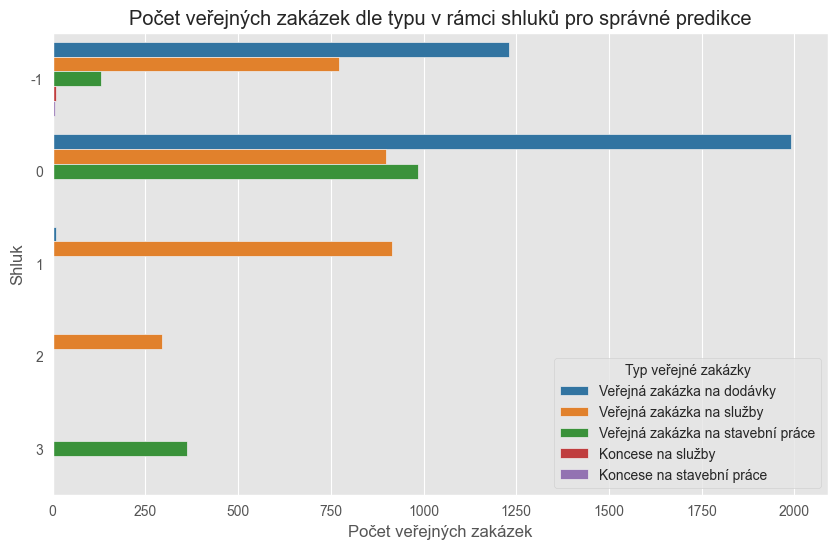

In [73]:
fig = plt.figure(figsize=(10, 6))
ax = sns.countplot(data=correct_for_DBSCAN, y='cluster', hue='type')
ax.set_ylabel('Shluk')
ax.set_xlabel('Počet veřejných zakázek')
plt.title('Počet veřejných zakázek dle typu v rámci shluků pro správné predikce')
plt.legend(title='Typ veřejné zakázky')
plt.show()

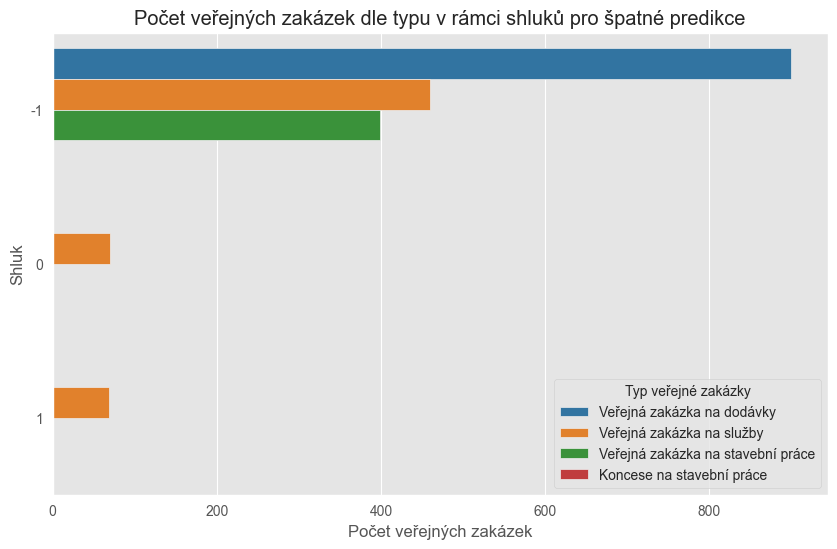

In [74]:
fig = plt.figure(figsize=(10, 6))
ax = sns.countplot(data=wrong_for_DBSCAN, y='cluster', hue='type')
ax.set_ylabel('Shluk')
ax.set_xlabel('Počet veřejných zakázek')
plt.title('Počet veřejných zakázek dle typu v rámci shluků pro špatné predikce')
plt.legend(title='Typ veřejné zakázky')
plt.show()

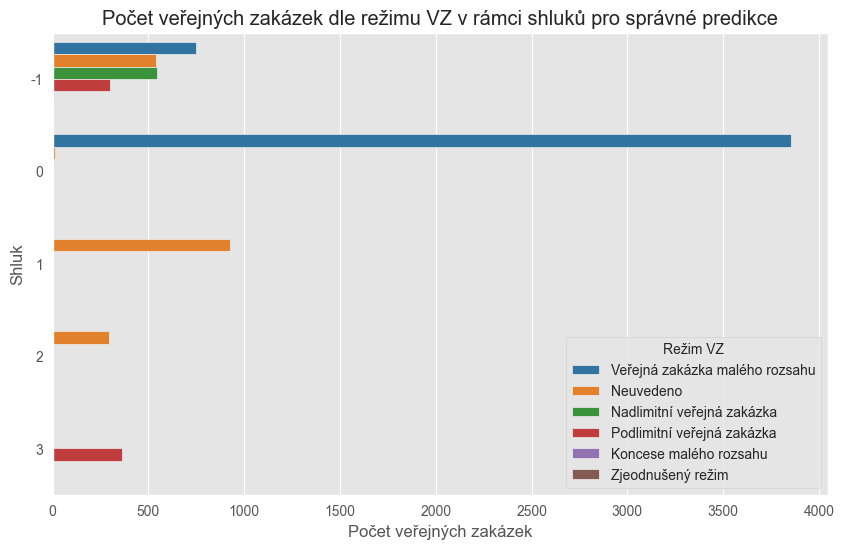

In [75]:
fig = plt.figure(figsize=(10, 6))
ax = sns.countplot(data=correct_for_DBSCAN, y='cluster', hue='public_contract_regime')
ax.set_ylabel('Shluk')
ax.set_xlabel('Počet veřejných zakázek')
plt.title('Počet veřejných zakázek dle režimu VZ v rámci shluků pro správné predikce')
plt.legend(title='Režim VZ')
plt.show()

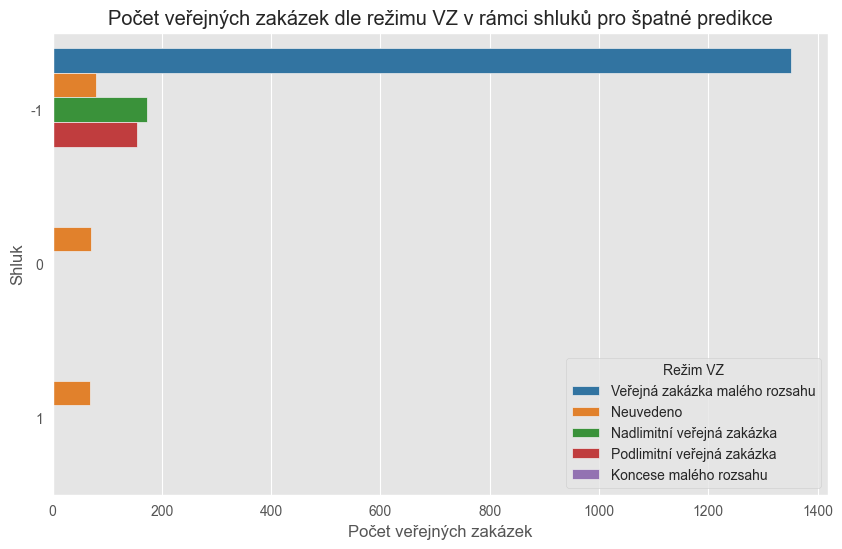

In [76]:
fig = plt.figure(figsize=(10, 6))
ax = sns.countplot(data=wrong_for_DBSCAN, y='cluster', hue='public_contract_regime')
ax.set_ylabel('Shluk')
ax.set_xlabel('Počet veřejných zakázek')
plt.title('Počet veřejných zakázek dle režimu VZ v rámci shluků pro špatné predikce')
plt.legend(title='Režim VZ')
plt.show()

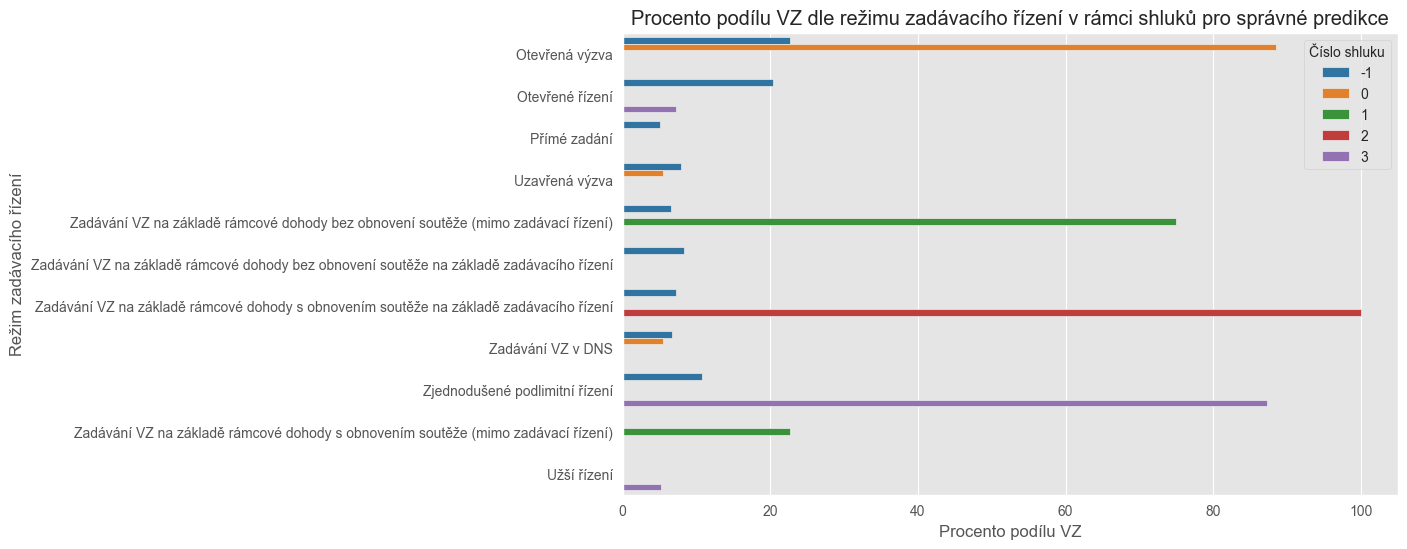

,cluster,type_of_procedure,count,percentage
3,-1,Otevřená výzva,487,22.693383
4,-1,Otevřené řízení,438,20.410065
5,-1,Přímé zadání,110,5.125815
6,-1,Uzavřená výzva,170,7.921715
10,-1,Zadávání VZ na základě rámcové dohody bez obno...,142,6.616962
11,-1,Zadávání VZ na základě rámcové dohody bez obno...,179,8.341100
13,-1,Zadávání VZ na základě rámcové dohody s obnove...,156,7.269338
14,-1,Zadávání VZ v DNS,144,6.710158
15,-1,Zjednodušené podlimitní řízení,231,10.764212
17,0,Otevřená výzva,3427,88.484379


In [77]:
percentages = correct_for_DBSCAN.groupby(['cluster', 'type_of_procedure']).size().reset_index(name='count')
percentages['percentage'] = percentages.groupby('cluster')['count'].transform(lambda x: x / x.sum() * 100)
# drop types of procedures with less than 5% of all data
percentages = percentages[percentages['percentage'] > 5]
# get bars tight together


plt.figure(figsize=(10, 6))
ax = sns.barplot(data=percentages, x='percentage', y='type_of_procedure', hue='cluster')
ax.set_ylabel('Režim zadávacího řízení')
ax.set_xlabel('Procento podílu VZ')
plt.title('Procento podílu VZ dle režimu zadávacího řízení v rámci shluků pro správné predikce')
plt.legend(title='Číslo shluku')
plt.show()
percentages

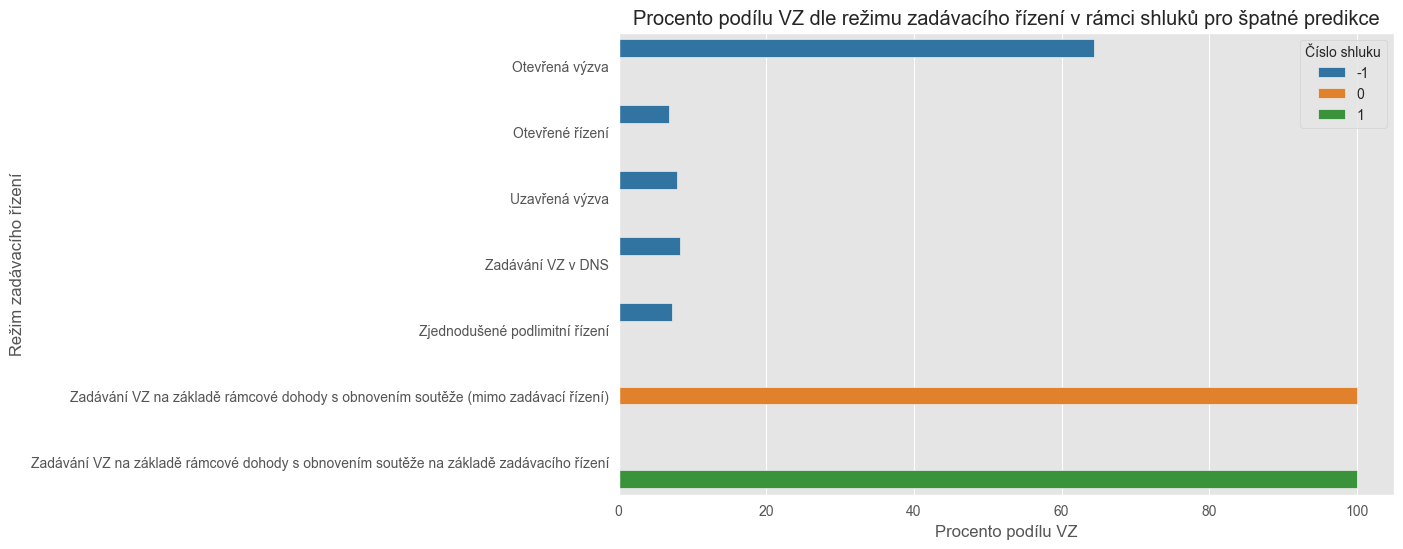

In [78]:
percentages = wrong_for_DBSCAN.groupby(['cluster', 'type_of_procedure']).size().reset_index(name='count')
percentages['percentage'] = percentages.groupby('cluster')['count'].transform(lambda x: x / x.sum() * 100)
# drop types of procedures with less than 5% of all data
percentages = percentages[percentages['percentage'] > 5]

plt.figure(figsize=(10, 6))
ax = sns.barplot(data=percentages, x='percentage', y='type_of_procedure', hue='cluster')
ax.set_ylabel('Režim zadávacího řízení')
ax.set_xlabel('Procento podílu VZ')
plt.title('Procento podílu VZ dle režimu zadávacího řízení v rámci shluků pro špatné predikce')
plt.legend(title='Číslo shluku')
plt.show()

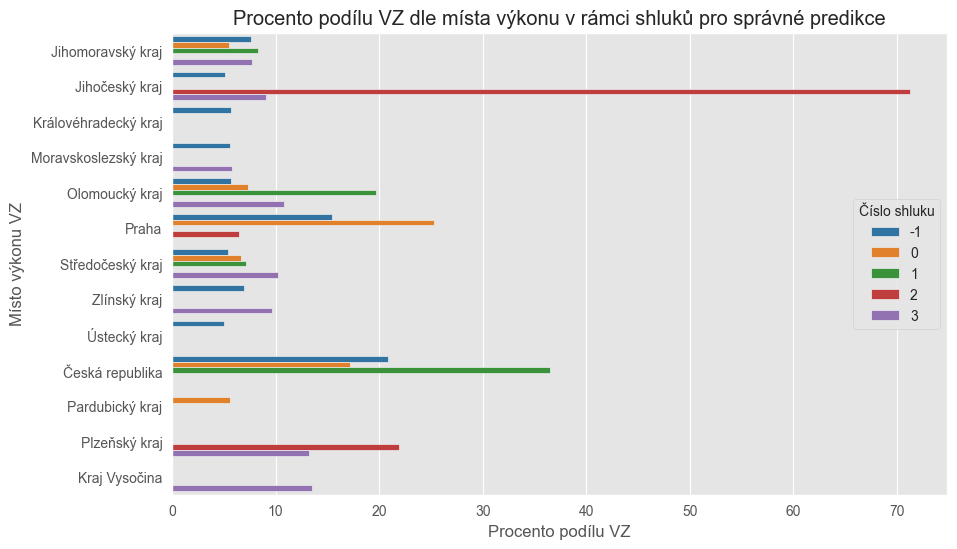

In [79]:
percentages = correct_for_DBSCAN.groupby(['cluster', 'place_of_performance']).size().reset_index(name='count')
percentages['percentage'] = percentages.groupby('cluster')['count'].transform(lambda x: x / x.sum() * 100)
percentages = percentages[percentages['percentage'] > 5]

plt.figure(figsize=(10, 6))
ax = sns.barplot(data=percentages, x='percentage', y='place_of_performance', hue='cluster')
ax.set_ylabel('Místo výkonu VZ')
ax.set_xlabel('Procento podílu VZ')
plt.title('Procento podílu VZ dle místa výkonu v rámci shluků pro správné predikce')
plt.legend(title='Číslo shluku')
plt.show()

    
    

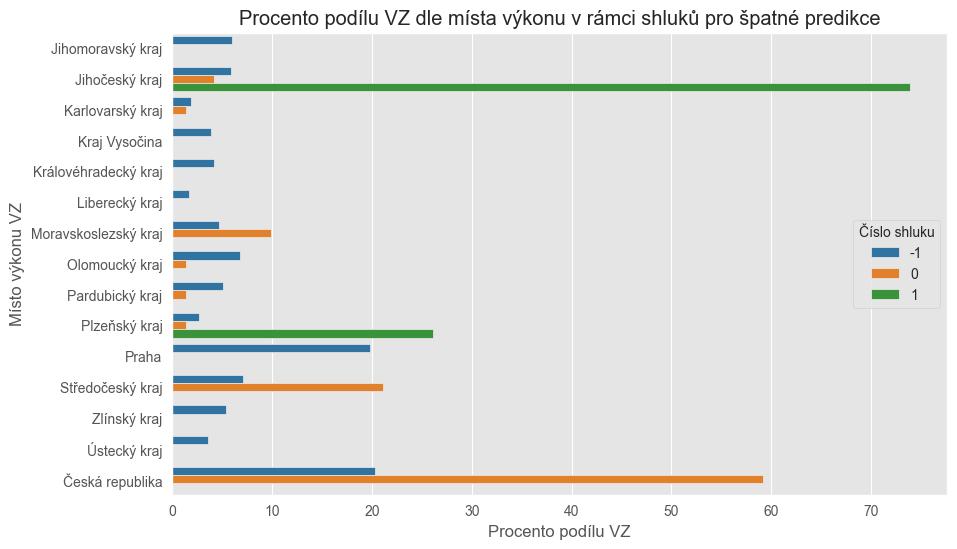

In [80]:
percentages = wrong_for_DBSCAN.groupby(['cluster', 'place_of_performance']).size().reset_index(name='count')
percentages['percentage'] = percentages.groupby('cluster')['count'].transform(lambda x: x / x.sum() * 100)
percentages = percentages[percentages['percentage'] > 1]

plt.figure(figsize=(10, 6))
ax = sns.barplot(data=percentages, x='percentage', y='place_of_performance', hue='cluster')
ax.set_ylabel('Místo výkonu VZ')
ax.set_xlabel('Procento podílu VZ')
plt.title('Procento podílu VZ dle místa výkonu v rámci shluků pro špatné predikce')
plt.legend(title='Číslo shluku')
plt.show()

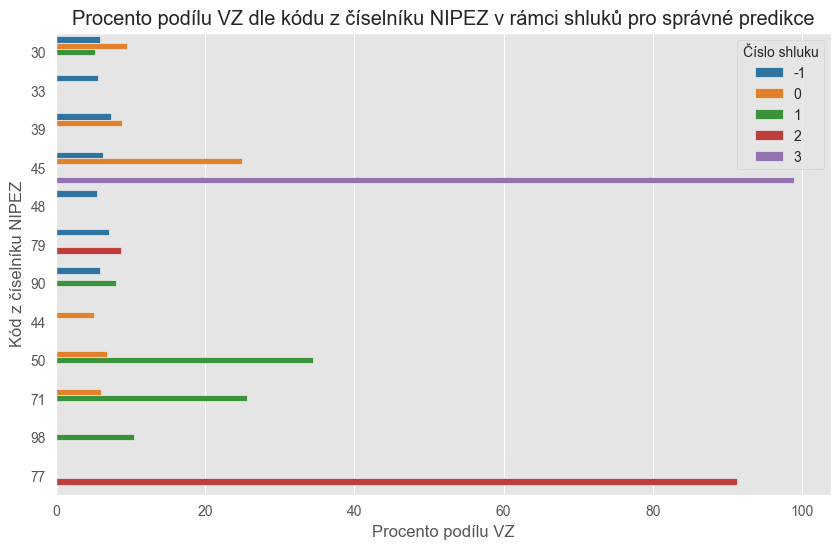

In [81]:
percentages = correct_for_DBSCAN.groupby(['cluster', 'codes']).size().reset_index(name='count')
percentages['percentage'] = percentages.groupby('cluster')['count'].transform(lambda x: x / x.sum() * 100)
percentages = percentages[percentages['percentage'] > 5]

plt.figure(figsize=(10, 6))
ax = sns.barplot(data=percentages, x='percentage', y='codes', hue='cluster')
ax.set_ylabel('Kód z číselníku NIPEZ')
ax.set_xlabel('Procento podílu VZ')
plt.title('Procento podílu VZ dle kódu z číselníku NIPEZ v rámci shluků pro správné predikce')
plt.legend(title='Číslo shluku')
plt.show()

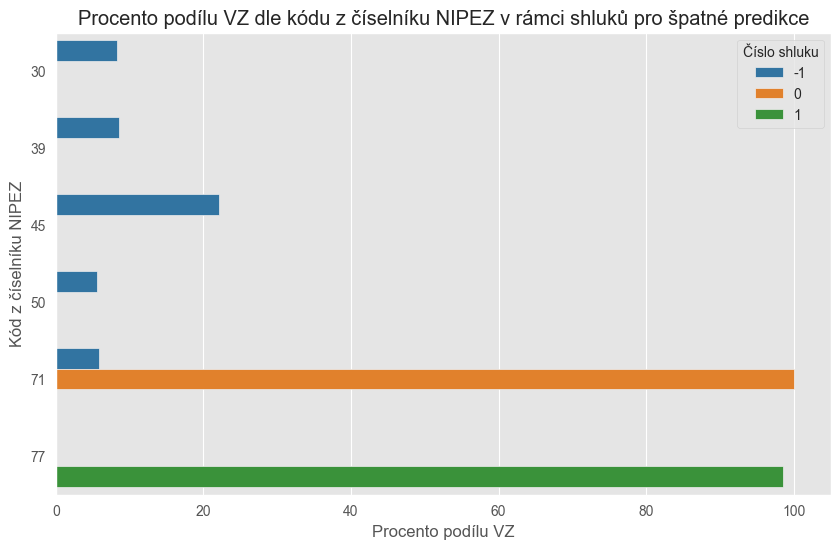

In [82]:
percentages = wrong_for_DBSCAN.groupby(['cluster', 'codes']).size().reset_index(name='count')
percentages['percentage'] = percentages.groupby('cluster')['count'].transform(lambda x: x / x.sum() * 100)
percentages = percentages[percentages['percentage'] > 5]

plt.figure(figsize=(10, 6))
ax = sns.barplot(data=percentages, x='percentage', y='codes', hue='cluster')
ax.set_ylabel('Kód z číselníku NIPEZ')
ax.set_xlabel('Procento podílu VZ')
plt.title('Procento podílu VZ dle kódu z číselníku NIPEZ v rámci shluků pro špatné predikce')
plt.legend(title='Číslo shluku')
plt.show()

In [83]:
# profile = ProfileReport(correct_for_DBSCAN[correct_for_DBSCAN['cluster'] == -1], title="Outliers_correct")
# profile.to_file("Outliers_correct.html")

In [84]:
# profile = ProfileReport(wrong_for_DBSCAN[wrong_for_DBSCAN['cluster'] == -1], title="Outliers_wrong")
# profile.to_file("Outliers_wrong.html")

### Vytvoření finálního modelu pro produkci na všech datech:

In [87]:
model_final = CatBoostClassifier(**trial.params, verbose=True, cat_features=['place_of_performance', 'public_contract_regime', 'type', 'type_of_procedure', 'distance'])
X_data = pd.concat([X_train, X_val, X_test])
y_data = pd.concat([y_train, y_val, y_test])
model_final.fit(X_data, y_data)
model_final.save_model("../webpages/catboost_model_production")

0:	learn: 0.6902092	total: 32.8ms	remaining: 11.4s
1:	learn: 0.6872522	total: 88ms	remaining: 15.2s
2:	learn: 0.6845070	total: 139ms	remaining: 16s
3:	learn: 0.6816548	total: 189ms	remaining: 16.3s
4:	learn: 0.6790704	total: 247ms	remaining: 16.9s
5:	learn: 0.6766214	total: 337ms	remaining: 19.2s
6:	learn: 0.6740613	total: 405ms	remaining: 19.8s
7:	learn: 0.6715223	total: 464ms	remaining: 19.7s
8:	learn: 0.6689036	total: 527ms	remaining: 19.8s
9:	learn: 0.6662627	total: 566ms	remaining: 19.1s
10:	learn: 0.6640318	total: 635ms	remaining: 19.4s
11:	learn: 0.6615006	total: 692ms	remaining: 19.4s
12:	learn: 0.6592317	total: 759ms	remaining: 19.6s
13:	learn: 0.6566919	total: 819ms	remaining: 19.5s
14:	learn: 0.6541625	total: 874ms	remaining: 19.4s
15:	learn: 0.6518714	total: 929ms	remaining: 19.3s
16:	learn: 0.6493120	total: 1.01s	remaining: 19.7s
17:	learn: 0.6468771	total: 1.06s	remaining: 19.4s
18:	learn: 0.6446552	total: 1.11s	remaining: 19.3s
19:	learn: 0.6423661	total: 1.17s	remaining